In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Preprocessing on Enrico data using MNE and ASR - cluster version
===============================================
We firstly import subject list from sbatch 
we define session list (1, 2), state list (VD, FA, OP), reject dict, 
then we import eeglab format Raw data of one state during one session for single subject with MNE package. We apply:
1) make sure that there is event 254 and event 255, and crop the raw data between 254 and 255
2) a notch filter to remove powerline artifact (50 Hz)
3) a 1Hz-100Hz band-pass filter

Then concatenate the data of the same session with annotation engineering, detail utils please turn to 
utils_preProcessingWorkflowJuly05.py
3) ASR and ICA fitting:
        
4) Autoreject and concatenate two sessions
====> output = full_epoch fif file that save the the full recording for one subject
Note: 
1. exception : subject 36, some subject can have several 254,255 events
------ please refer to excel Enrico recording summary.xlsx

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from utils_ASR import *
from utils_preProcessingWorkflowJuly05 import *
from scipy.linalg import toeplitz
from scipy import signal
import sys
import encodings
import os

matplotlib.use('Agg')
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
# raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
# montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
# # report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
# full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
#
##################### OS path in cluster ######################################################################
raw_data_path = '/mnt/data/gansheng/raw_data/'
montage_fname = '/mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
full_epochs_path = '/mnt/data/gansheng/preClean_data/'


########################################## Algorithme parameter ############################################
cutoff = 4
pca_n_comp = 0.98
decim = 2

########################################## Initialization parameter##########################################
subj_list = [sys.argv[1]]
# subj_list = ['19']
session_list=['1','2']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']
state_list = ['VD','FA','OP']
power_freq_array = [50]
reject_raw_data_session1 = {'10':['FA','VD'],'21':['VD'],'29':['VD','FA','OP'],'30':['FA'],'36':['OP'],'35':['VD']}
reject_raw_data_session2 = {'10':['VD'], '21':['FA','VD'],
                '22':['OP'], '57':['OP','FA'], '82':['FA','OP','VD']}

# bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
bad_channels={'94':{'1':['P2']},
              '07':{'1':['Iz']},
              '12':{'1':['P2']},
              '14':{'1':['P2']},
              '19':{'1':['P2','TP8','T7']},
              '25':{'1':['T8'],'2':['FC1','C3','PO4']},
              '26':{'1':['T8'],'2':['CPz']},
              '28':{'2':['CP2','PO7','Oz','POz']},
              '29':{'2':['T7','F6','F4','F8']},
              '30':{'1':['C6','F6','FC6']},
              '32':{'1':['P2'],'2':['P2','TP7']},
              '34':{'1':['P2'],'2':['P2']},
              '35':{'1':['T7','T8'],'2':['T8','PO8']},
              '36':{'1':['P2','PO4'],'2':['P2','PO4']},
              '37':{'1':['Iz']},
              '38':{'2':['TP8']}
             }
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis


################################ step00: cut and filter data and concatenate 3 recording in one session ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file
for subj in subj_list:
    psd_full_figs=[]
    psd_full_caption=[]
    session2conctn_list=[]
    ############### single subject report ###########################
    rep = Report(image_format = 'png', subject = 'subj0'+subj)
    
    for session in session_list:
        psd_figs=[]
        psd_captions=[]
        ASR_figs=[]
        ASR_captions=[]
        ica_figs=[]
        ica_captions=[]
        autoR_figs=[]
        autoR_captions=[]
        reject_state=[]
        conctn_list = []
        conctn_anno_list=[]
#         conctn_dict = {}
        if subj in eval('reject_raw_data_session'+session).keys():
            reject_state = eval('reject_raw_data_session'+session)[subj]
            print("the rejected states of subject {} in session {} are {}".format(subj,session,reject_state))
        for state in state_list:
            raw_fname = raw_data_path + 'subj0'+subj+'_'+state+session+'_mast.set'
            if state in reject_state:
                continue
            elif os.path.isfile(raw_fname)==False:
                print('raw data file is missing: subject{}, session{}, state{}'.format(subj,session,state))
                
            else:
                raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
                events = mne.events_from_annotations(raw)
                if subj == '36' and session == '2' and state == 'VD':
                    raw.crop(tmin=220)
                    events = mne.events_from_annotations(raw)
                    events = events_time_forward(events,220)
                
                events_coding=events[1]
                events=np.asarray(events[0])  
                if '254.0' not in events_coding.keys():
                    raw.annotations.append(onset=0,duration=0,description='254.0')
                    events = mne.events_from_annotations(raw)
                    events_coding=events[1]
                    events=np.asarray(events[0])  
                if '255.0' not in events_coding.keys():
                    raw.annotations.append(onset=events[-1][0]/512,duration=0,description='255.0')
                    events = mne.events_from_annotations(raw)
                    events_coding=events[1]
                    events=np.asarray(events[0])  

                events_code_start = events_coding['254.0']
                start = events[events[:,2]==events_code_start][0][0]
                events_code_end = events_coding['255.0']
                stop = events[events[:,2]==events_code_end][0][0]
                    
                raw_cut_filt = raw.copy()
                raw_cut_filt.crop(tmin = start/raw.info['sfreq'], tmax = stop/raw.info['sfreq'])
                raw_cut_filt.notch_filter(freqs=power_freq_array)
                raw_cut_filt.filter(l_freq=1,h_freq=100)
                psd_figs.append(raw_cut_filt.plot_psd(show = False))
                psd_captions.append('subject '+subj+"'s "+'psd plot after cut and filtering in session' 
                                    +session+ ' during '+state+' state')
                ############ annotation engineering ################
                index_dlt=0
                for i in range(raw_cut_filt.annotations.__len__()):
                    if (raw_cut_filt.annotations.__getitem__(i-index_dlt)['description']) not in ['131.0','132.0','255.0']:
                        raw_cut_filt.annotations.delete(i-index_dlt)
                        index_dlt+=1                       
                    else: 
                        continue
                mne_annotation_recode_by_adding(session=session,state=state,annotations=raw_cut_filt.annotations)

                conctn_anno_list.append(raw_cut_filt.annotations)
                conctn_list.append(raw_cut_filt)

################### Concatenation process #################################
        if len(conctn_list)== 0:
            continue
        else:        
            full_array = conctn_list[0]._data
            full_info = conctn_list[0].info
            del conctn_list[0]
            for raw2conctn in conctn_list:
                full_array = np.concatenate((full_array,raw2conctn._data),axis=1)
            raw_full = mne.io.RawArray(full_array,info = full_info)
            full_annotation = conctn_anno_list[0]
            del conctn_anno_list[0]
            for annos2conctn in conctn_anno_list:
                mne_annotation_postpone (pptime=full_annotation.__getitem__(full_annotation.__len__()-1)['onset'], 
                                             annotations=annos2conctn)
                full_annotation = full_annotation.__add__(annos2conctn)

            raw_full.set_annotations(full_annotation)
            if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
                raw_full.info['bads']=bad_channels[subj][session]
 

    ###########raw_full now is for one session 

            ############### step01: epochs engineering - calibration-epochs-ASR #################################
            rawCalibAsr = raw_full.copy()
            rawCalibAsr = rawCalibAsr.crop(tmin=10,tmax=150)
            rawCalibAsr_noYW = rawCalibAsr.copy()
            rawCalibAsr._data,iirstate = YW_filter(rawCalibAsr._data, rawCalibAsr.info['sfreq'],None)
            rawVEOG= rawCalibAsr.copy()
            rawVEOG = rawVEOG.pick_channels(['VEOG'])
            VEOG_data = np.squeeze(rawVEOG.get_data())
            peak_locs, peak_eeg = mne.preprocessing.peak_finder(VEOG_data, thresh = 110e-6)
            lengthblink = 0.5*rawCalibAsr.info['sfreq']
            startremoveblink = peak_locs-(lengthblink/2)
            stopremoveblink = peak_locs+(lengthblink/2)
            NbsampCalibAsrWindow = len(VEOG_data)
            startremoveblink = np.abs((startremoveblink>0)*startremoveblink)
            stopremoveblink =  (stopremoveblink>NbsampCalibAsrWindow-1)*NbsampCalibAsrWindow + (stopremoveblink<NbsampCalibAsrWindow-1)*stopremoveblink
            Mask=np.zeros(NbsampCalibAsrWindow)
            for ix2remove in range(len(startremoveblink)):
                Mask[int(startremoveblink[ix2remove]):int(stopremoveblink[ix2remove])]=1
            rawCalibAsr_noYW.pick_types(eeg=True)
            rawdata_noblink = np.delete(rawCalibAsr_noYW.get_data(),np.where(Mask),axis=1)

            SignalCalib=np.delete(rawdata_noblink,np.where(np.abs(rawdata_noblink)>75e-6)[1],axis=1)
            ref_maxbadchannels = 0.2
            ref_tolerances = [-3.5,5.5]
            ref_wndlen = 1
            SignalClean,sample_mask = clean_windows(SignalCalib,rawCalibAsr.info['sfreq'],ref_maxbadchannels,ref_tolerances,ref_wndlen)
            SignalClean_raw = mne.io.RawArray(SignalClean,rawCalibAsr_noYW.info)
            ASR_figs.append(SignalClean_raw.plot(scalings = 150e-6,n_channels=64,duration = 10,show = False))
            ASR_captions.append('SignalClean plot same scaling as raw 150e-6')
            srate = rawCalibAsr.info['sfreq']
            cutoff = 4
            asr_state = asr_calibrate(SignalClean,srate,cutoff)
            if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
                raw_bad = raw_full.copy()
                raw_bad.pick(raw_bad.info['bads'])
            raw4detect = raw_full.copy()
            raw4detect.pick_types(eeg=True)
            raw_full_eeg=raw_full.copy()
            raw_full_eeg.pick_types(eeg=True)
            raw_full_eog=raw_full.copy()
            raw_full_eog.pick_types(eog=True)
            raw4detect._data,iirstate = YW_filter(raw4detect._data,raw4detect.info['sfreq'],None)


            events = mne.events_from_annotations(raw_full)
            for i in range(len(events[0][:,2])):
                events[0][i][2]=int(float(dict_getValue(events[1],events[0][i][2])))

            for key in events[1].keys():
                events[1][key] = int(float(key))

            events_time_description = events[0]   
            i=0
            while i <len(events_time_description[:,2]):
                if events_time_description[i][2]==255:
                    events_time_description=np.delete(events_time_description,i,0)
                else:
                    i+=1
            events_dict=events[1]
            events_dict=removeItem_from_dict(events_dict,'255.0')

            sfreq=raw_full.info['sfreq']   
            i=0
            overflow=False

            while overflow==False:
                if events_time_description[i,0]+sfreq*2>=events_time_description[-1][0]:
                    overflow=True
                elif events_time_description[i+1,0]-events_time_description[i,0]>sfreq*2:
                    events_time_description=np.insert(events_time_description,i+1,
                                                      [sfreq*2+events_time_description[i,0],0,events_time_description[i,2]],
                                                      axis=0)
                    i+=1
                else:
                    i+=1


            events=(events_time_description,events_dict)

            epochs4detect=mne.Epochs(raw4detect,events=events[0],event_id = events[1],tmin=0, tmax=2,preload=True)
            epochs_full=mne.Epochs(raw_full_eeg,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
            epochs_eog_raw_filt = mne.Epochs(raw_full_eog,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
            if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
                epochs_bad_channels = mne.Epochs(raw_bad,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True) 
            Data4detect = epochs4detect.get_data()
            Data2correct = epochs_full.get_data()
            DataClean = np.zeros((Data2correct.shape))
            num_epochs2correct = 0
            num_epochscorrected = 0
            for i_epoch in range(Data2correct.shape[0]):
                num_epochs2correct+=1
                Epoch4detect = Data4detect[i_epoch,:,:] 
                Epoch2corr = Data2correct[i_epoch,:,:]    
                DataClean[i_epoch,:,:],reconstruct = asr_process_on_epoch(Epoch2corr,Epoch4detect,asr_state)

                if reconstruct ==True:
                    num_epochscorrected +=1
            print('ASR correcting rate is {}'.format(num_epochscorrected/num_epochs2correct))
            ASR_figs.append(plt.figure())
            ASR_captions.append('ASR correcting rate is '+str(num_epochscorrected/num_epochs2correct))

            epochs_ASR_clean =   mne.EpochsArray(DataClean,info=epochs_full.info,events=events[0],event_id = events[1])
            epochs_ASR_clean.add_channels([epochs_eog_raw_filt])
            if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
                epochs_ASR_clean.add_channels([epochs_bad_channels])
                epochs_ASR_clean.interpolate_bads()
    #         epochs_ASR_clean.plot(scalings=100e-6,n_epochs=5)


            ############### step02 ICA components check ##########################
            ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
            ica.fit(epochs_ASR_clean,decim=decim)
            title = 'Sources related to %s artifacts (red)'
            eog_inds, scores = ica.find_bads_eog(epochs_ASR_clean,ch_name='VEOG')
            ica_figs.append(ica.plot_scores(scores, exclude=eog_inds, title=title % 'Veog', labels='Veog',show = False))
            ica_captions.append('VEOG component correlation plot')

            if eog_inds ==[]:
                print("no Veog component is found")
            else:
                ica_figs.append(ica.plot_components(eog_inds, title=title % 'Veog', colorbar=True, show = False))
                ica_captions.append('VEOG component plot')


            eog_inds, scores = ica.find_bads_eog(epochs_ASR_clean,ch_name='HEOG')
            ica_figs.append(ica.plot_scores(scores, exclude=eog_inds, title=title % 'Heog', labels='Heog', show= False))
            ica_captions.append('HEOG component correlation plot')
            #ica.plot_sources(epochs.average(), exclude=eog_inds, title=title % 'Veog')
            if eog_inds ==[]:
                print("no Heog component is found")
            else:
                ica_figs.append(ica.plot_components(eog_inds, title=title % 'Heog', colorbar=True, show = False))
                ica_captions.append('HEOG component correlation plot')

            for i in range(len(ica.plot_components(inst=epochs_ASR_clean))):
                ica_figs.append(ica.plot_components(inst=epochs_ASR_clean,show=False)[i])
                ica_captions.append('ica_components figure'+str(i))
            ica_figs.append(ica.get_sources(epochs_ASR_clean).plot(picks='all',show=False))
            ica_captions.append('ica source plot')

            ################### step03 AutoRejection ##################################
            picks = mne.pick_types(epochs_ASR_clean.info, meg=False, eeg=True, stim=False,
                           eog=False)
            ar = AutoReject(picks=picks,random_state= 11,verbose='tqdm')
            ar=ar.fit(epochs_ASR_clean)

            picks = mne.pick_types(epochs_ASR_clean.info, meg=False, eeg=True, stim=False,
                   eog=False)
            ar = AutoReject(picks=picks,random_state= 11,verbose='tqdm')
            ar=ar.fit(epochs_ASR_clean)
            epochs_autorejected, reject_log = ar.transform(epochs_ASR_clean, return_log=True)
            autoR_figs.append(epochs_autorejected.plot_drop_log())
            autoR_captions.append('autorejecting rate')
            autoR_figs.append(reject_log.plot_epochs(epochs_ASR_clean,scalings=150e-6))
            autoR_captions.append('a glimpse of autorejecting epochs')

            threshes = ar.threshes_
            unit = r'uV'
            scaling = 1e6

            thres_hist=plt.figure(figsize=(6, 5))
            plt.tick_params(axis='x', which='both', bottom='off', top='off')
            plt.tick_params(axis='y', which='both', left='off', right='off')

            plt.hist(scaling * np.array(list(threshes.values())), 30,
                     color='g', alpha=0.4)
            plt.xlabel('Threshold (%s)' % unit)
            plt.ylabel('Number of sensors')
            plt.tight_layout()
            autoR_figs.append(thres_hist)
            autoR_captions.append('threshold histogram')

            rep.add_figs_to_section(figs=psd_figs, captions=psd_captions, section = 'session'+session+'spectral plot', 
                                    image_format = 'svg')
            rep.add_figs_to_section(figs=ASR_figs, captions=ASR_captions, section = 'session'+session+'ASR plot', 
                                    image_format = 'svg')
            rep.add_figs_to_section(figs=ica_figs, captions=ica_captions, section = 'session'+session+'ica plot', 
                                    image_format = 'svg')
            rep.add_figs_to_section(figs=autoR_figs, captions=autoR_captions, section = 'session'+session+
                                    'autoRejection plot', image_format = 'svg')

            session2conctn_list.append(epochs_autorejected)
            plt.close('all')
    full_epochs_fname = full_epochs_path + 'subj0'+subj+'full_epo.fif'
    full_epochs_autorejected = mne.concatenate_epochs(session2conctn_list)
    psd_full_figs.append(full_epochs_autorejected.plot_psd())
    psd_full_caption.append('psd of epochs after preprocessing')
    rep.add_figs_to_section(figs=psd_full_figs, captions=psd_full_caption, section = 'preprocessed full epochs plot',
                            image_format = 'svg')
    full_epochs_autorejected.save(full_epochs_fname,overwrite = True)
        
    f_report = report_path + 'subj0' + subj+'.html'
    rep.save(f_report, open_browser = False, overwrite = True)

        



/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/mne/local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


OSError: /mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs not found.

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj036_FA2_mast.fdt
Reading 0 ... 295935  =      0.000 ...   577.998 secs...
Effective window size : 4.000 (s)


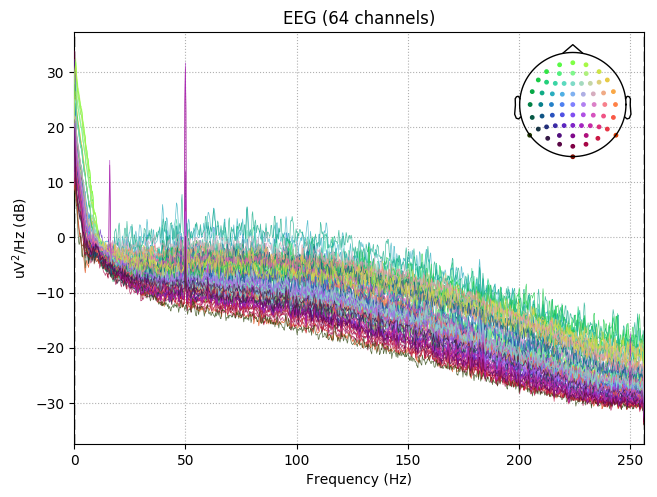

In [10]:
################ Visualization of bad channels ######################
################## with the help of psd plot ######################
%matplotlib qt
plt.close('all')
import mne
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
subj ='36'
state='VD'
session='2'
raw_fname = raw_data_path + 'subj0'+subj+'_'+state+session+'_mast.set'
montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
montage_biosemi=mne.channels.read_montage(montage_fname)
raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')                
raw.plot(scalings=50e-6,n_channels=32)
raw.plot_psd()

Effective window size : 4.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


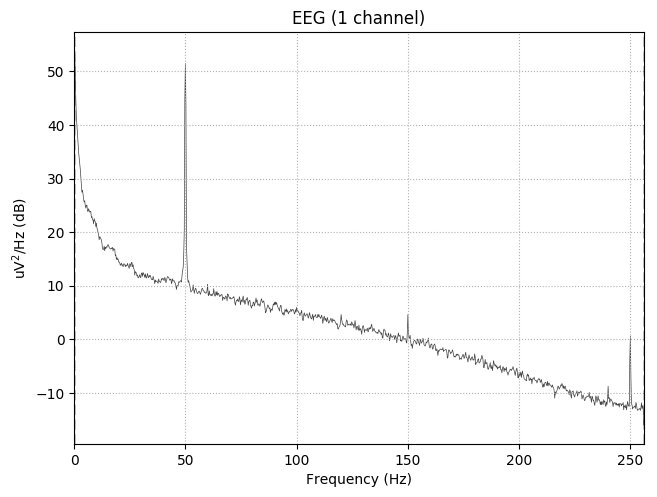

In [168]:
#check single channel
raw.plot_psd(picks='PO8')

In [55]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Preprocessing on Enrico data using MNE and ASR
===============================================
We firstly define subject dictionary as well as state list, reject dict, then we import eeglab format 
Raw data with MNE package. We apply:
1) a notch filter to remove powerline artifact (50 Hz)
2) a 1Hz-100Hz band-pass filter

Then concatenate the data of the same session
3) ASR and ICA fitting:
        ====> output = full_epoch fif file that save the the full recording for one subject

Note: version designed for custer-run 

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from utils_ASR import *
from utils_preProcessingWorkflowJuly05 import *
from scipy.linalg import toeplitz
from scipy import signal
import sys
import encodings
import os

matplotlib.use('Agg')
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
# # report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
# full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
#
##################### OS path in cluster ######################################################################
# raw_data_path = '/mnt/data/gansheng/raw_data/'
# montage_fname = '/mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
full_epochs_path = '/mnt/data/gansheng/preClean_data/'


########################################## Algorithme parameter ############################################
cutoff = 4
pca_n_comp = 0.98
decim = 2

########################################## Initialization parameter##########################################
# subj_list = [sys.argv[1]]
subj_list = ['36']
session_list=['2']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']
state_list = ['VD']
power_freq_array = [50]
reject_raw_data_session1 = {'10':['FA','VD'],'21':['VD'],'29':['VD','FA','OP'],'30':['FA'],'36':['OP'],'35':['VD']}
reject_raw_data_session2 = {'10':['VD'], '21':['FA','VD'],
                '22':['OP'], '57':['OP','FA'], '82':['FA','OP','VD']}

# bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
bad_channels={'94':{'1':['P2']},
              '07':{'1':['Iz']},
              '12':{'1':['P2']},
              '14':{'1':['P2']},
              '19':{'1':['P2','TP8','T7']},
              '25':{'1':['T8'],'2':['FC1','C3','PO4']},
              '26':{'1':['T8'],'2':['CPz']},
              '28':{'2':['CP2','PO7','Oz','POz']},
              '29':{'2':['T7','F6','F4','F8']},
              '30':{'1':['C6','F6','FC6']},
              '32':{'1':['P2'],'2':['P2','TP7']},
              '34':{'1':['P2'],'2':['P2']},
              '35':{'1':['T7','T8'],'2':['T8','PO8']},
              '36':{'1':['P2','PO4'],'2':['P2','PO4']},
              '37':{'1':['Iz']},
              '38':{'2':['TP8']}
             }
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis


################################ step00: cut and filter data and concatenate 3 recording in one session ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file
for subj in subj_list:
    psd_full_figs=[]
    psd_full_caption=[]
    session2conctn_list=[]
    ############### single subject report ###########################
    rep = Report(image_format = 'png', subject = 'subj0'+subj)
    
    for session in session_list:
        psd_figs=[]
        psd_captions=[]
        ASR_figs=[]
        ASR_captions=[]
        ica_figs=[]
        ica_captions=[]
        autoR_figs=[]
        autoR_captions=[]
        reject_state=[]
        conctn_list = []
        conctn_anno_list=[]
#         conctn_dict = {}
        if subj in eval('reject_raw_data_session'+session).keys():
            reject_state = eval('reject_raw_data_session'+session)[subj]
            print("the rejected states of subject {} in session {} are {}".format(subj,session,reject_state))
        for state in state_list:
            raw_fname = raw_data_path + 'subj0'+subj+'_'+state+session+'_mast.set'
            if state in reject_state:
                continue
            elif os.path.isfile(raw_fname)==False:
                print('raw data file is missing: subject{}, session{}, state{}'.format(subj,session,state))
            else:
                raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
                events = mne.events_from_annotations(raw)
                if subj == '36' and session == '2' and state == 'VD':
                    raw.crop(tmin=220)
                    events = mne.events_from_annotations(raw)
                    events = events_time_forward(events,220)
                    

                events_coding=events[1]
                events=np.asarray(events[0])  
                if '254.0' not in events_coding.keys():
                    raw.annotations.append(onset=0,duration=0,description='254.0')
                    events = mne.events_from_annotations(raw)
                    events_coding=events[1]
                    events=np.asarray(events[0])  
                if '255.0' not in events_coding.keys():
                    raw.annotations.append(onset=events[-1][0]/512,duration=0,description='255.0')
                    events = mne.events_from_annotations(raw)
                    events_coding=events[1]
                    events=np.asarray(events[0])  

                events_code_start = events_coding['254.0']
                start = events[events[:,2]==events_code_start][0][0]
                events_code_end = events_coding['255.0']
                stop = events[events[:,2]==events_code_end][0][0]
                    
                raw_cut_filt = raw.copy()
                raw_cut_filt.crop(tmin = start/raw.info['sfreq'], tmax = stop/raw.info['sfreq'])
                raw_cut_filt.notch_filter(freqs=power_freq_array)
                raw_cut_filt.filter(l_freq=1,h_freq=100)
                psd_figs.append(raw_cut_filt.plot_psd(show = False))
                psd_captions.append('subject '+subj+"'s "+'psd plot after cut and filtering in session' 
                                    +session+ ' during '+state+' state')
                ############ annotation engineering ################
                index_dlt=0
                for i in range(raw_cut_filt.annotations.__len__()):
                    if (raw_cut_filt.annotations.__getitem__(i-index_dlt)['description']) not in ['131.0','132.0','255.0']:
                        raw_cut_filt.annotations.delete(i-index_dlt)
                        index_dlt+=1                       
                    else: 
                        continue
                mne_annotation_recode_by_adding(session=session,state=state,annotations=raw_cut_filt.annotations)


Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj036_VD2_mast.fdt
Reading 0 ... 388607  =      0.000 ...   758.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio